In [1]:
%matplotlib inline


Single Field of View for sequential single-molecule FISH processed in 3d
========================================================================

This notebook walks through a work flow that analyzes one field of view of a mouse gene panel from
the Allen Institute for Brain Science, using the starfish package.

This example processes an experiment with a single round from a single field of view of sequential
smFISH data taken from mouse primary visual cortex. These data are unpublished, and were kindly
contributed by the Allen Institute for Brain Science as a part of the SpaceTx consortium
project.

The data consist of 45 images from 1 round, 1 channels, and 33 z-planes. Each image is
(2048, 2048) (y, x). There are no test data.



In [16]:
from typing import Optional, Tuple
from IPython import get_ipython

from matplotlib import pyplot as plt
import numpy as np
import starfish
import starfish.data
from starfish import FieldOfView, IntensityTable

# equivalent to %gui qt
ipython = get_ipython()
ipython.magic("gui qt5")

Define image filters
--------------------
The 3d smFISH workflow run by the Allen runs a bandpass filter to remove high and low frequency
signal and blurs over z with a 1-pixel gaussian to smooth the signal over the z-axis.

low-intensity signal is (stringently) clipped from the images before and after these filters.


In [5]:
# bandpass filter to remove cellular background and camera noise
bandpass = starfish.image.Filter.Bandpass(lshort=.5, llong=7, threshold=0.0)

# gaussian blur to smooth z-axis
glp = starfish.image.Filter.GaussianLowPass(
    sigma=(1, 0, 0),
    is_volume=True
)

# pre-filter clip to remove low-intensity background signal
clip1 = starfish.image.Filter.Clip(p_min=50, p_max=100)

# post-filter clip to eliminate all but the highest-intensity peaks
clip2 = starfish.image.Filter.Clip(p_min=99, p_max=100, is_volume=True)

Define a spot detection method
------------------------------
Spots are detected using a spot finder based on trackpy's locate method, which identifies
local intensity maxima, and spots are matched to the gene they represent by looking them up in a
codebook that records which (round, channel) matches which gene target.


In [4]:
tlmpf = starfish.spots.DetectSpots.TrackpyLocalMaxPeakFinder(
    spot_diameter=5,  # must be odd integer
    min_mass=0.02,
    max_size=2,  # this is max radius
    separation=7,
    noise_size=0.65,  # this is not used because preprocess is False
    preprocess=False,
    percentile=10,  # this is irrelevant when min_mass, spot_diameter, and max_size are set properly
    verbose=True,
    is_volume=True,
)

Construct the pipeline
----------------------


In [6]:
# override print to print to stderr for cromwell
from functools import partial
import sys
print = partial(print, file=sys.stderr)

def processing_pipeline(
    experiment: starfish.Experiment,
    fov_name: str,
    n_processes: Optional[int]=None
) -> Tuple[starfish.ImageStack, starfish.IntensityTable]:
    """Process a single field of view of an experiment

    Parameters
    ----------
    experiment : starfish.Experiment
        starfish experiment containing fields of view to analyze
    fov_name : str
        name of the field of view to process
    n_processes : int

    Returns
    -------
    starfish.IntensityTable :
        decoded IntensityTable containing spots matched to the genes they are hybridized against
    """

    print("Loading images...")
    primary_image = experiment[fov_name].get_image(FieldOfView.PRIMARY_IMAGES)
    all_intensities = list()
    codebook = experiment.codebook
    
    images = enumerate(experiment[fov_name].iterate_image_type(FieldOfView.PRIMARY_IMAGES))

    for image_number, primary_image in images:

        print(f"Filtering image {image_number}...")
        filter_kwargs = dict(
            in_place=True,
            verbose=True,
            n_processes=n_processes
        )
        print("Applying Clip...")
        clip1.run(primary_image, **filter_kwargs)
        print("Applying Bandpass...")
        bandpass.run(primary_image, **filter_kwargs)
        print("Applying Gaussian Low Pass...")
        glp.run(primary_image, **filter_kwargs)
        print("Applying Clip...")
        clip2.run(primary_image, **filter_kwargs)

        print("Calling spots...")
        spot_attributes = tlmpf.run(primary_image)
        all_intensities.append(spot_attributes)

    spot_attributes = IntensityTable.concatenate_intensity_tables(all_intensities)

    print("Decoding spots...")
    decoded = codebook.decode_per_round_max(spot_attributes)
    decoded = decoded[decoded["total_intensity"] > .025]
    
    print("Processing complete.")

    return primary_image, decoded

Load data, run pipeline, display results
----------------------------------------


In [8]:
experiment = starfish.Experiment.from_json("/Users/brian/work/data/the_other_other/czi_mouse_single_round_SpaceTx/experiment.json")

In [7]:

image, intensities = processing_pipeline(experiment, fov_name='fov_001')

# uncomment the below line to visualize the output with the spot calls.
# viewer = starfish.display(image, intensities)

NameError: name 'experiment' is not defined

In [10]:
viewer = starfish.display(image, intensities)

In [8]:
idf = intensities.to_features_dataframe()

In [116]:
image0

<starfish.ImageStack (r: 1, c: 3, z: 34, y: 2048, x: 2048)>

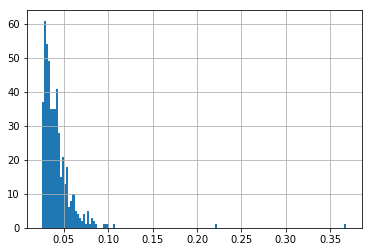

In [15]:
idf["raw_mass"].hist(bins=150)

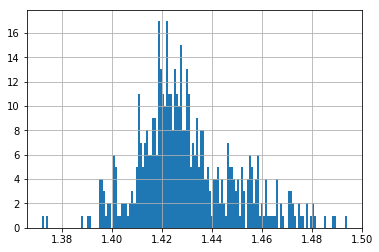

In [16]:
idf["radius"].hist(bins=150)

In [17]:
experiment

<starfish.Experiment (FOVs=3)>
{
fov_000: <starfish.FieldOfView>
  Primary Image: <slicedimage.TileSet (c: 3, r: 1, z: 34, x: 2048, y: 2048)>
  Auxiliary Images:
    nuclei: <slicedimage.TileSet (c: 1, r: 1, z: 34, x: 2048, y: 2048)>
fov_001: <starfish.FieldOfView>
  Primary Image: <slicedimage.TileSet (c: 3, r: 1, z: 34, x: 2048, y: 2048)>
  Auxiliary Images:
    nuclei: <slicedimage.TileSet (c: 1, r: 1, z: 34, x: 2048, y: 2048)>
fov_002: <starfish.FieldOfView>
  Primary Image: <slicedimage.TileSet (c: 3, r: 1, z: 34, x: 2048, y: 2048)>
  Auxiliary Images:
    nuclei: <slicedimage.TileSet (c: 1, r: 1, z: 34, x: 2048, y: 2048)>
}

In [9]:
image2, intensities2 = processing_pipeline(experiment, fov_name='fov_002')

Loading images...
100%|██████████| 102/102 [00:11<00:00,  8.67it/s]
Filtering image 0...
Applying Clip...
102it [00:04, 21.70it/s]
Applying Bandpass...
102it [00:17,  5.81it/s]
Applying Gaussian Low Pass...
3it [00:00, 68.20it/s]
Applying Clip...
3it [00:00, 30.97it/s]
Calling spots...
Decoding spots...
Processing complete.


In [20]:
image0, intensities0 = processing_pipeline(experiment, fov_name='fov_000')

Loading images...
100%|██████████| 102/102 [00:07<00:00, 13.80it/s]
Filtering image 0...
Applying Clip...
102it [00:05, 20.41it/s]
Applying Bandpass...
102it [00:20,  4.72it/s]
Applying Gaussian Low Pass...
3it [00:00, 90.00it/s]
Applying Clip...
3it [00:00, 49.74it/s]
Calling spots...
Decoding spots...
Processing complete.


In [22]:
image1, intensities1 = processing_pipeline(experiment, fov_name='fov_001')

Loading images...
100%|██████████| 102/102 [00:08<00:00, 12.12it/s]
Filtering image 0...
Applying Clip...
102it [00:04, 23.20it/s]
Applying Bandpass...
102it [00:17,  3.30it/s]
Applying Gaussian Low Pass...
3it [00:00, 94.66it/s]
Applying Clip...
3it [00:00, 27.05it/s]
Calling spots...
Decoding spots...
Processing complete.


In [25]:
from starfish.types import Axes

In [37]:
imcrop, axes = image.get_slice({Axes.CH: slice(0, 0)})

In [37]:
from starfish.types import Axes
from starfish import ImageStack
from napari import ViewerApp
from vispy.color import Colormap
import glob 
import os

In [42]:
imc = ImageStack.from_numpy(imcrop)

100%|██████████| 34/34 [00:00<00:00, 57.21it/s]


In [42]:
import skimage.io

starfish_volume = skimage.io.imread("/Users/brian/work/data/the_other_other/preprocessed_fov_000.TIFF")
print(starfish_volume.shape)


(34, 2048, 2048, 3)


### Now visualize 3 FOVs with raw images, `starfish` spots and the existing allen pipeline spots

In [67]:
viewer = ViewerApp()
cmapTops = [(0.,0.,1.,1.), (0.0,1.0, 0.1,1.), (1., 0.0, 0.0,1.0)]
cmapNames = ['b', 'g','r']



# this 

summary_directory = "/Users/brian/work/data/the_other_other/czi_mouse_single_round/summary/"


for i, [iStack, iSpots,ind] in enumerate(
    zip([ image0,image1, image2], [intensities0, intensities1,intensities2],['006','007','008'] )):

    size= 2048
    iLocation = [0, -size*i*0.9,0,0]    # should extract this from `xc` `yc`, but can't be bothered at the moment
    
    npyfiles = sorted(glob.glob(os.sep.join([summary_directory,"*003_"+ind+"*.npy"])))
    allen_spots= []
    for f in npyfiles:
        initial = np.load(f)
        allen_spots.append(np.column_stack([initial[:,1],initial[:,0]+ iLocation[1]*np.ones_like(initial[:,0]), 
                                           initial[:,2], np.zeros_like(initial[:,0:2])]))


    gene_names=list(iSpots.groupby("target").groups.keys())
    for ch in range(3):
        imcrop, axes = iStack.get_slice({Axes.CH: slice(ch, ch)})
        imcrop = np.squeeze(np.swapaxes(np.swapaxes(imcrop,3,0), 4,1))
        imview = viewer.add_image(imcrop, clim_range=[np.min(imcrop), 0.001])
        imview.translate=iLocation
        imview.colormap = Colormap([(0, 0, 0, 1), cmapTops[ch]])
        imview.blending = 'additive'
        starfish_spots = np.column_stack([iSpots[iSpots.groupby("target").groups[gene_names[ch]]]["x"]+iLocation[0],
                                       iSpots[iSpots.groupby("target").groups[gene_names[ch]]]["y"]+iLocation[1],
                                      iSpots[iSpots.groupby("target").groups[gene_names[ch]]]["z"],
                                      np.zeros_like(iSpots[iSpots.groupby("target").groups[gene_names[ch]]]["z"]),
                                      np.zeros_like(iSpots[iSpots.groupby("target").groups[gene_names[ch]]]["z"])])
        starfish_marker_layer = viewer.add_markers(starfish_spots)
        starfish_marker_layer.face_color=None
        starfish_marker_layer.edge_color=cmapNames[ch]
        starfish_marker_layer.n_dimensional = True
        allen_marker_layer = viewer.add_markers(allen_spots[ch])
        allen_marker_layer.symbol = 'cross'
        allen_marker_layer.face_color=None
        allen_marker_layer.edge_color=cmapNames[ch]
        allen_marker_layer.n_dimensional = True        
        


In [65]:
j=88